In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats
from scipy.stats import gaussian_kde
warnings.filterwarnings('ignore')

Настройка стиля графиков

In [88]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

Загрузка данных

In [89]:
df_transactions = pd.read_excel('datasets/FinalDataset.xlsx')
df_addresses = pd.read_csv('datasets/Featuers_Extraction.csv')

# Анализ датасетов

## 1. Базовый обзор датасетов

Датасет транзакций

In [90]:
print(f"Записей: {df_transactions.shape[0]:,}")
print(f"Колонок: {df_transactions.shape[1]}")
print(f"Типы данных:")
for dtype, count in df_transactions.dtypes.value_counts().items():
    print(f"- {dtype}: {count} колонок")

Записей: 71,250
Колонок: 18
Типы данных:
- int64: 9 колонок
- object: 8 колонок
- float64: 1 колонок


Датасет адресов

In [91]:

print(f"Уникальных адресов: {df_addresses.shape[0]:,}")
print(f"Колонок: {df_addresses.shape[1]}")
print(f"Типы данных:")
for dtype, count in df_addresses.dtypes.value_counts().items():
    print(f"- {dtype}: {count} колонок")

Уникальных адресов: 73,034
Колонок: 25
Типы данных:
- float64: 14 колонок
- int64: 10 колонок
- object: 1 колонок


Визуализация пропусков в датасете транзакций

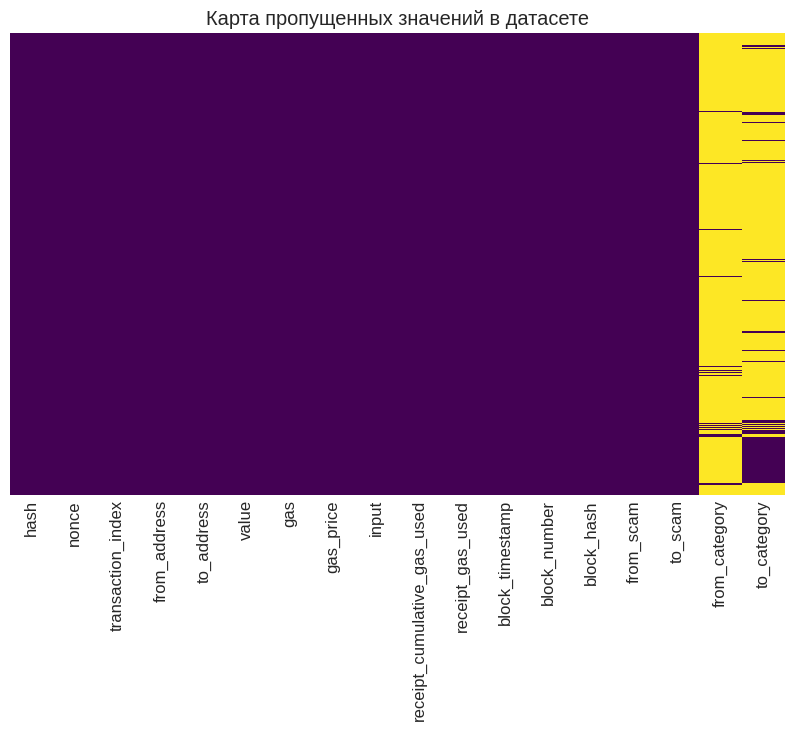

In [92]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_transactions.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Карта пропущенных значений в датасете')
plt.show()

Визуализация пропусков в датасете адресов

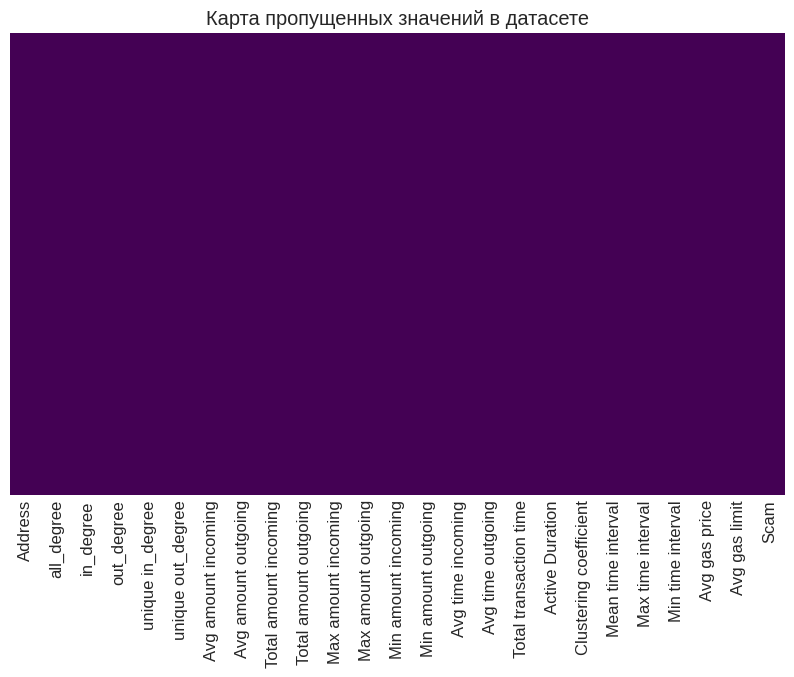

In [93]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_addresses.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Карта пропущенных значений в датасете')
plt.show()

Построим матрицу корреляции между признаками и с целевой переменной

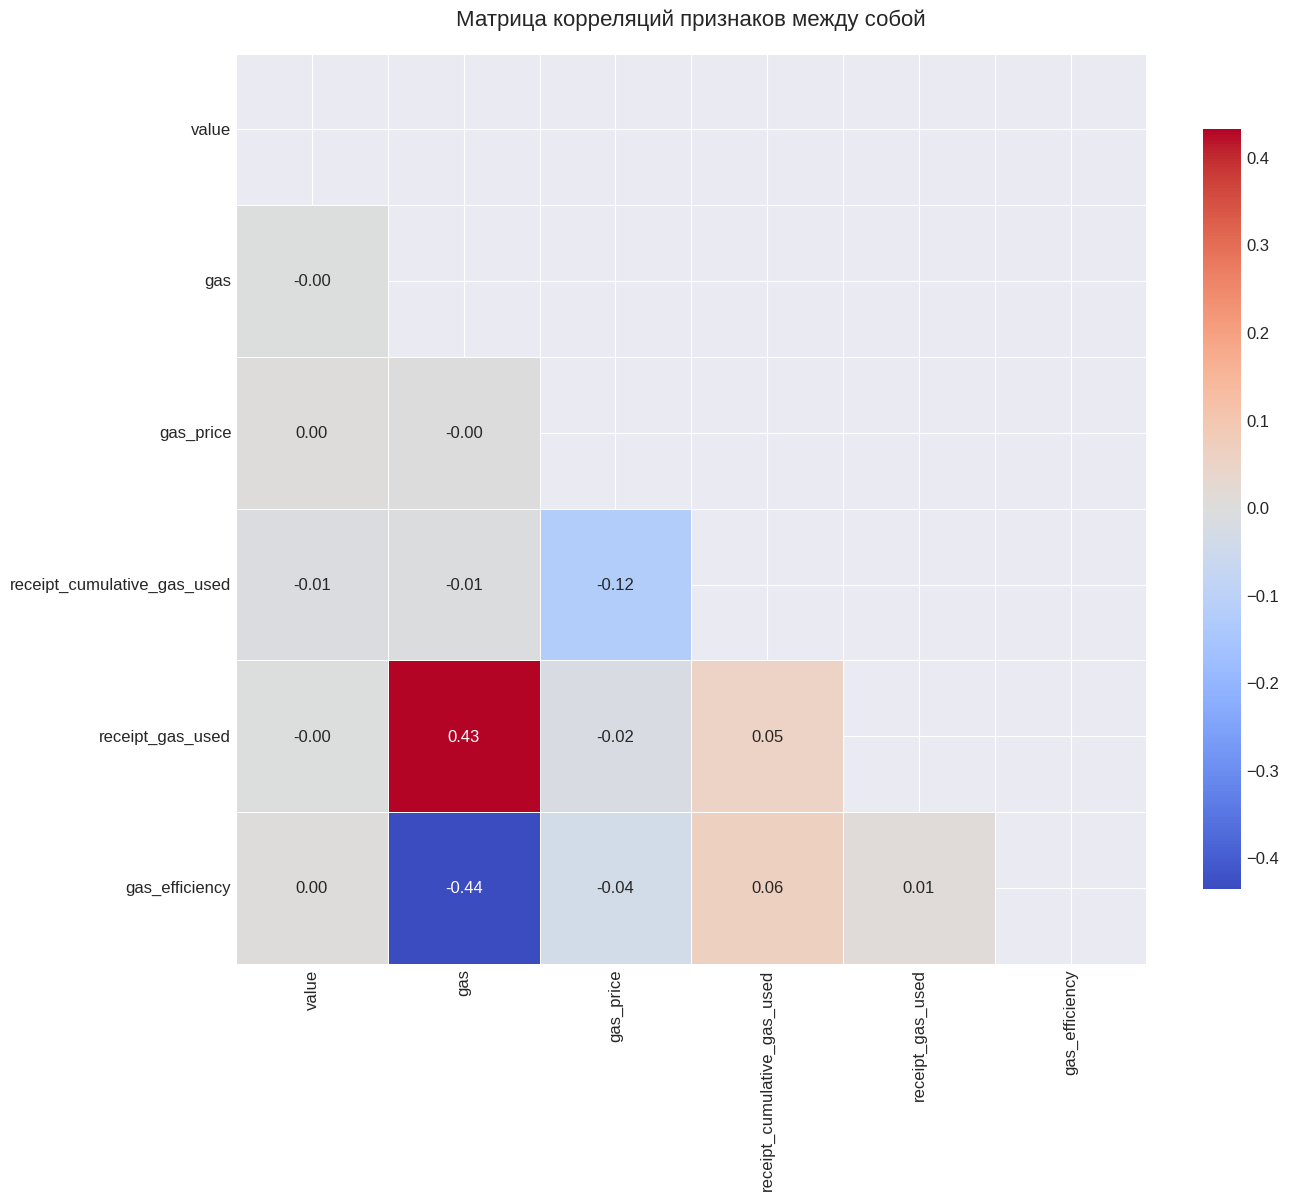

Корреляция признаков с целевой переменной (is_scam):
receipt_cumulative_gas_used   : +0.1105
receipt_gas_used              : +0.1051
gas_efficiency                : +0.0646
gas                           : +0.0227
value                         : -0.0157
gas_price                     : -0.0485


In [139]:
df = df_transactions.copy()

df['is_scam'] = df[['from_scam', 'to_scam']].any(axis=1).astype(int)

df = df.drop(labels=['from_scam', 'to_scam', 'transaction_index', 'block_number', 'nonce'], axis=1)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_cols if col != 'is_scam']

correlation_matrix = df[numeric_features].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Матрица корреляций признаков между собой', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

print("Корреляция признаков с целевой переменной (is_scam):")
correlation_with_target = df[numeric_features + ['is_scam']].corr()['is_scam'].sort_values(ascending=False)
for feature, corr in correlation_with_target.items():
    if feature != 'is_scam':
        print(f"{feature:30}: {corr:+.4f}")

## 2. Анализ целевых переменных и аномалий

Создадим общую целевую переменную, т.к. в нашей задаче не важно какой именно аккаунт является аномальным/мошенническим, а сам факт аномальной/мошеннической транзакции

1.2. Анализ переменной from_scam


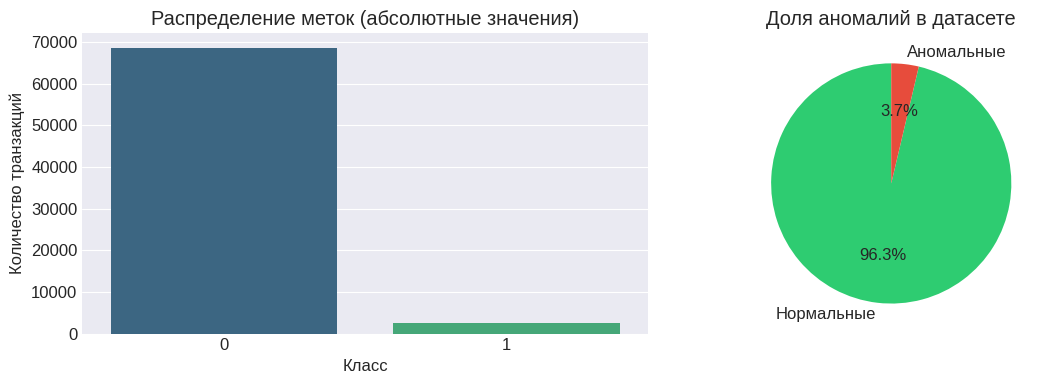

1.2. Анализ переменной to_scam


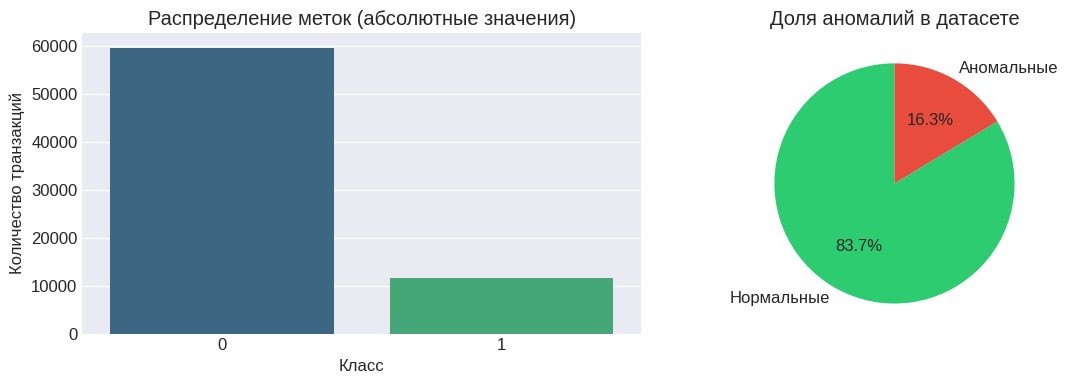

1.2. Анализ переменной is_scam


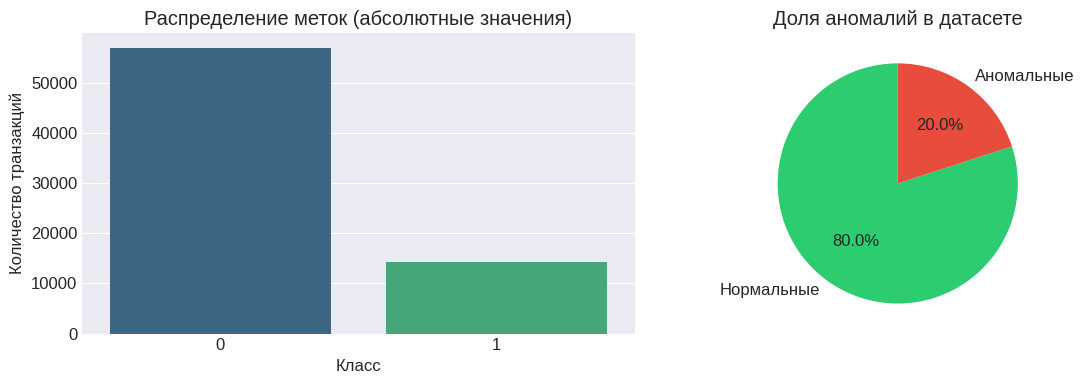

In [94]:
df_transactions['is_scam'] = (df_transactions['from_scam'] == 1) | (df_transactions['to_scam'] == 1)
df_transactions['is_scam'] = df_transactions['is_scam'].astype(int)

target_cols = ['from_scam', 'to_scam', 'is_scam']

for target_col in target_cols:
    print(f"1.2. Анализ переменной {target_col}")
    target_distribution = df_transactions[target_col].value_counts()
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.barplot(x=target_distribution.index, y=target_distribution.values, ax=ax[0], palette='viridis')
    ax[0].set_title('Распределение меток (абсолютные значения)')
    ax[0].set_xlabel('Класс')
    ax[0].set_ylabel('Количество транзакций')
    
    ax[1].pie(target_distribution.values, labels=['Нормальные', 'Аномальные'], 
              autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#e74c3c'])
    ax[1].set_title('Доля аномалий в датасете')
    
    plt.tight_layout()
    plt.show()

## 3. Анализ распространения аномалий во времени

Преобразуем время block_timestamp в формат времени pandas для дальнейшей удобной работы с данными

In [95]:
df_transactions['block_timestamp'] = pd.to_datetime(
df_transactions['block_timestamp'], 
errors='coerce',
format='mixed',
)

df_time = df_transactions.copy()

In [96]:
df_time['date'] = df_time['block_timestamp'].dt.date
df_time['hour'] = df_time['block_timestamp'].dt.hour
df_time['day_of_week'] = df_time['block_timestamp'].dt.dayofweek
df_time['month'] = df_time['block_timestamp'].dt.month

In [97]:
daily_stats = df_time.groupby('date', dropna=False).agg({
    'is_scam': ['count', 'sum', 'mean']
}).round(4)

daily_stats.columns = ['total_transactions', 'scam_transactions', 'scam_ratio']
daily_stats = daily_stats.reset_index()

## Визуализация:

Оценим распределение транзакций по дням

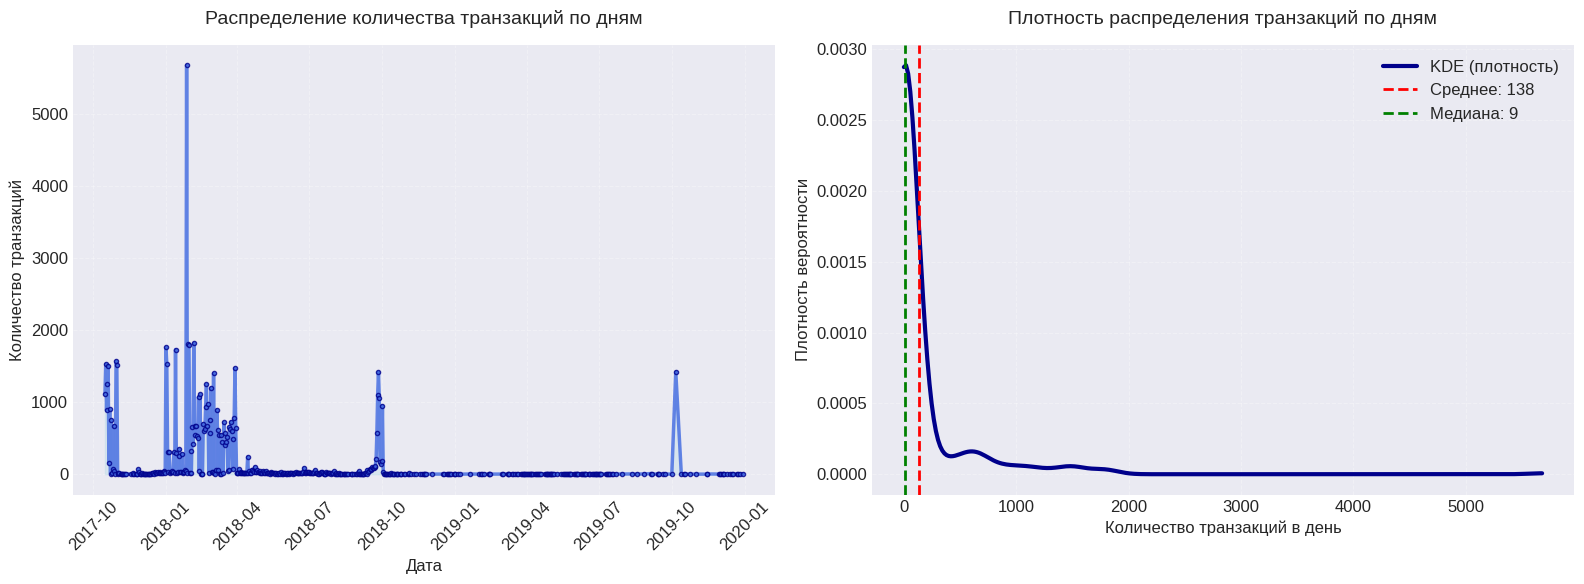

In [98]:
daily_counts = df_time.groupby('date').size()
dates = pd.to_datetime(daily_counts.index)
counts = daily_counts.values

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(dates, counts, linewidth=2.5, color='royalblue', alpha=0.8, 
             marker='o', markersize=3, markeredgecolor='darkblue')
axes[0].fill_between(dates, 0, counts, alpha=0.3, color='lightblue')
axes[0].set_title('Распределение количества транзакций по дням', fontsize=14, pad=15)
axes[0].set_xlabel('Дата', fontsize=12)
axes[0].set_ylabel('Количество транзакций', fontsize=12)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].tick_params(axis='x', rotation=45)

kde = stats.gaussian_kde(counts)
x_range = np.linspace(counts.min(), counts.max(), 300)
axes[1].plot(x_range, kde(x_range), linewidth=3, color='darkblue', 
             label='KDE (плотность)')

axes[1].axvline(x=counts.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Среднее: {counts.mean():.0f}')
axes[1].axvline(x=np.median(counts), color='green', linestyle='--', linewidth=2,
                label=f'Медиана: {np.median(counts):.0f}')

axes[1].set_title('Плотность распределения транзакций по дням', fontsize=14, pad=15)
axes[1].set_xlabel('Количество транзакций в день', fontsize=12)
axes[1].set_ylabel('Плотность вероятности', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

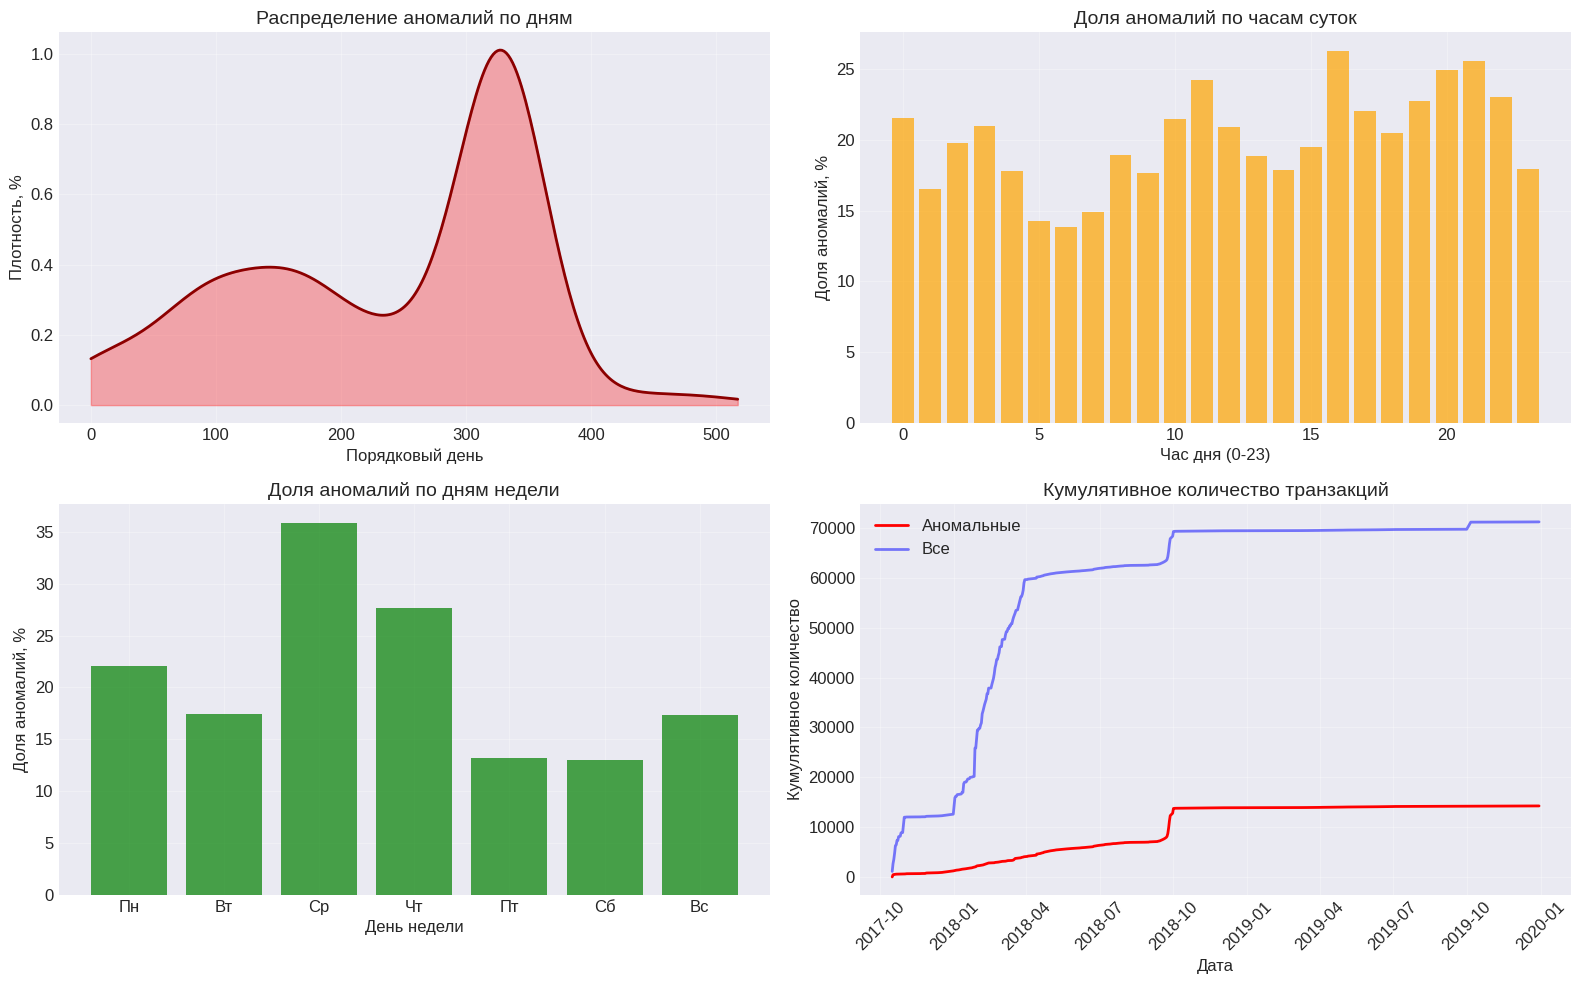

In [99]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

dates = pd.to_datetime(daily_stats['date'])
scam_counts = daily_stats['scam_transactions'].values

dates_numeric = np.arange(len(dates))

kde = stats.gaussian_kde(dates_numeric, weights=scam_counts, bw_method=0.3)
x_range = np.linspace(dates_numeric.min(), dates_numeric.max(), 300)
kde_values = kde(x_range)

kde_values_normalized = kde_values / kde_values.sum() * 100

axes[0, 0].fill_between(x_range, 0, kde_values_normalized, alpha=0.3, color='red')
axes[0, 0].plot(x_range, kde_values_normalized, linewidth=2, color='darkred')

axes[0, 0].set_title('Распределение аномалий по дням', fontsize=14)
axes[0, 0].set_xlabel('Порядковый день')
axes[0, 0].set_ylabel('Плотность, %')
axes[0, 0].grid(True, alpha=0.3)

hourly_stats = df_time.groupby('hour')['is_scam'].mean() * 100
axes[0, 1].bar(hourly_stats.index, hourly_stats.values, 
                color='orange', alpha=0.7)
axes[0, 1].set_title('Доля аномалий по часам суток', fontsize=14)
axes[0, 1].set_xlabel('Час дня (0-23)')
axes[0, 1].set_ylabel('Доля аномалий, %')
axes[0, 1].grid(True, alpha=0.3)

day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
daily_stats_week = df_time.groupby('day_of_week')['is_scam'].mean() * 100
axes[1, 0].bar(daily_stats_week.index, daily_stats_week.values,
                color='green', alpha=0.7)
axes[1, 0].set_title('Доля аномалий по дням недели', fontsize=14)
axes[1, 0].set_xlabel('День недели')
axes[1, 0].set_ylabel('Доля аномалий, %')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(day_names)
axes[1, 0].grid(True, alpha=0.3)

daily_stats_sorted = daily_stats.sort_values('date')
daily_stats_sorted['cumulative_scam'] = daily_stats_sorted['scam_transactions'].cumsum()
daily_stats_sorted['cumulative_total'] = daily_stats_sorted['total_transactions'].cumsum()

axes[1, 1].plot(daily_stats_sorted['date'], daily_stats_sorted['cumulative_scam'],
                label='Аномальные', linewidth=2, color='red')
axes[1, 1].plot(daily_stats_sorted['date'], daily_stats_sorted['cumulative_total'],
                label='Все', linewidth=2, color='blue', alpha=0.5)
axes[1, 1].set_title('Кумулятивное количество транзакций', fontsize=14)
axes[1, 1].set_xlabel('Дата')
axes[1, 1].set_ylabel('Кумулятивное количество')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Выводы:

Исходя из проанализированных данных можно сделать вывод, что основная часть аномалий расположены ближе к концу датасета, что позволяет нам сделать вывод о том, что мы не сможем использовать хронологическое разделение в нашей работе, т.к. распределение максимально смещено вправо (в самых последних датах в датасете основная часть аномальных транзакций)

# 4. Анализ длины цепочек транзакций

В связи с тем, что в качестве решения задачи поиска аномалий можно использовать модели, работающие с последовательностями (Transformer, LSTM и т.д.), стоит проанализировать длину цепочек, т.к. это напрямую будет влиять на возможность и качество реализации данных методов.

## 4.1. Анализ 'from_address'

In [100]:
from_counts = df_transactions['from_address'].value_counts()

print(f"Всего уникальных отправителей: {len(from_counts):,}")

Всего уникальных отправителей: 34,069


Статистика по количеству транзакций с адресов:

In [101]:
print(f"- Медиана: {from_counts.median():.1f} транзакций")
print(f"- Среднее: {from_counts.mean():.1f} транзакций")
print(f"- Максимум: {from_counts.max():,} транзакций")
print(f"- Минимум: {from_counts.min()} транзакций")

- Медиана: 1.0 транзакций
- Среднее: 2.1 транзакций
- Максимум: 1,701 транзакций
- Минимум: 1 транзакций


Распределение по процентилям:

In [102]:
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
for p in percentiles:
    value = from_counts.quantile(p)
    print(f"{p*100:3.0f}% отправителей имеют ≤ {value:.0f} транзакций")

 25% отправителей имеют ≤ 1 транзакций
 50% отправителей имеют ≤ 1 транзакций
 75% отправителей имеют ≤ 1 транзакций
 90% отправителей имеют ≤ 1 транзакций
 95% отправителей имеют ≤ 2 транзакций
 99% отправителей имеют ≤ 14 транзакций
100% отправителей имеют ≤ 1701 транзакций


Анализ по различным порогам

In [103]:
thresholds = [1, 2, 3, 5, 10, 20, 50]
for threshold in thresholds:
    count = (from_counts >= threshold).sum()
    percentage = count / len(from_counts) * 100
    print(f"≥{threshold:2d} транзакций: {count:7,} адресов ({percentage:5.1f}%)")

≥ 1 транзакций:  34,069 адресов (100.0%)
≥ 2 транзакций:   2,936 адресов (  8.6%)
≥ 3 транзакций:   1,346 адресов (  4.0%)
≥ 5 транзакций:     808 адресов (  2.4%)
≥10 транзакций:     472 адресов (  1.4%)
≥20 транзакций:     254 адресов (  0.7%)
≥50 транзакций:     109 адресов (  0.3%)


## 4.2. Анализ 'to_address'

In [104]:
to_counts = df_transactions['to_address'].value_counts()

print(f"Всего уникальных отправителей: {len(from_counts):,}")

Всего уникальных отправителей: 34,069


Статистика по количеству транзакций на адресы:

In [105]:
print(f"- Медиана: {to_counts.median():.1f} транзакций")
print(f"- Среднее: {to_counts.mean():.1f} транзакций")
print(f"- Максимум: {to_counts.max():,} транзакций")
print(f"- Минимум: {to_counts.min()} транзакций")

- Медиана: 1.0 транзакций
- Среднее: 1.8 транзакций
- Максимум: 3,109 транзакций
- Минимум: 1 транзакций


Распределение по процентилям:

In [106]:
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
for p in percentiles:
    value = to_counts.quantile(p)
    print(f"{p*100:3.0f}% отправителей имеют ≤ {value:.0f} транзакций")

 25% отправителей имеют ≤ 1 транзакций
 50% отправителей имеют ≤ 1 транзакций
 75% отправителей имеют ≤ 1 транзакций
 90% отправителей имеют ≤ 1 транзакций
 95% отправителей имеют ≤ 2 транзакций
 99% отправителей имеют ≤ 6 транзакций
100% отправителей имеют ≤ 3109 транзакций


Анализ по различным порогам

In [107]:
thresholds = [1, 2, 3, 5, 10, 20, 50]
for threshold in thresholds:
    count = (to_counts >= threshold).sum()
    percentage = count / len(to_counts) * 100
    print(f"≥{threshold:2d} транзакций: {count:7,} адресов ({percentage:5.1f}%)")

≥ 1 транзакций:  40,619 адресов (100.0%)
≥ 2 транзакций:   2,479 адресов (  6.1%)
≥ 3 транзакций:   1,006 адресов (  2.5%)
≥ 5 транзакций:     500 адресов (  1.2%)
≥10 транзакций:     269 адресов (  0.7%)
≥20 транзакций:     149 адресов (  0.4%)
≥50 транзакций:      76 адресов (  0.2%)


## 4.3. Совместный анализ

Просмотрим пересечения

In [108]:
unique_from = set(df_transactions['from_address'].unique())
unique_to = set(df_transactions['to_address'].unique())
intersection = unique_from & unique_to

print(f"Адресов только как отправители: {len(unique_from - intersection):,}")
print(f"Адресов только как получатели: {len(unique_to - intersection):,}")
print(f"Адресов и как отправители и как получатели: {len(intersection):,}")

Адресов только как отправители: 32,415
Адресов только как получатели: 38,965
Адресов и как отправители и как получатели: 1,654


## 4.4. Анализ для аномальных транзакций 

In [109]:
scam_transactions = df_transactions[df_transactions['is_scam'] == 1]
normal_transactions = df_transactions[df_transactions['is_scam'] == 0]

scam_from_counts = scam_transactions['from_address'].value_counts()
normal_from_counts = normal_transactions['from_address'].value_counts()

print(f"Уникальных отправителей в аномальных транзакциях: {len(scam_from_counts):,}")
print(f"Уникальных отправителей в нормальных транзакциях: {len(normal_from_counts):,}")

Уникальных отправителей в аномальных транзакциях: 4,718
Уникальных отправителей в нормальных транзакциях: 29,449


Сравнение средней длины цепочек

In [110]:
print(f"Аномальные: {scam_from_counts.mean():.2f} транзакций на адрес")
print(f"Нормальные: {normal_from_counts.mean():.2f} транзакций на адрес")

Аномальные: 3.02 транзакций на адрес
Нормальные: 1.94 транзакций на адрес


Проверка статистической значимости, по 4700 семплов, потому что количество с scam_from_counts ограничено 4700 эксемплярами

In [111]:
sample_scam = scam_from_counts.head(4700).values
sample_normal = normal_from_counts.head(4700).values

if len(sample_scam) > 30 and len(sample_normal) > 30:
    t_stat, p_value = stats.ttest_ind(sample_scam, sample_normal, equal_var=False)
    print(f"t-тест p-value: {p_value:.4f}")

t-тест p-value: 0.0000


т.к. t-тест p-value меньше 0.05 - разница статистически значима

## 4.5. Визуализация

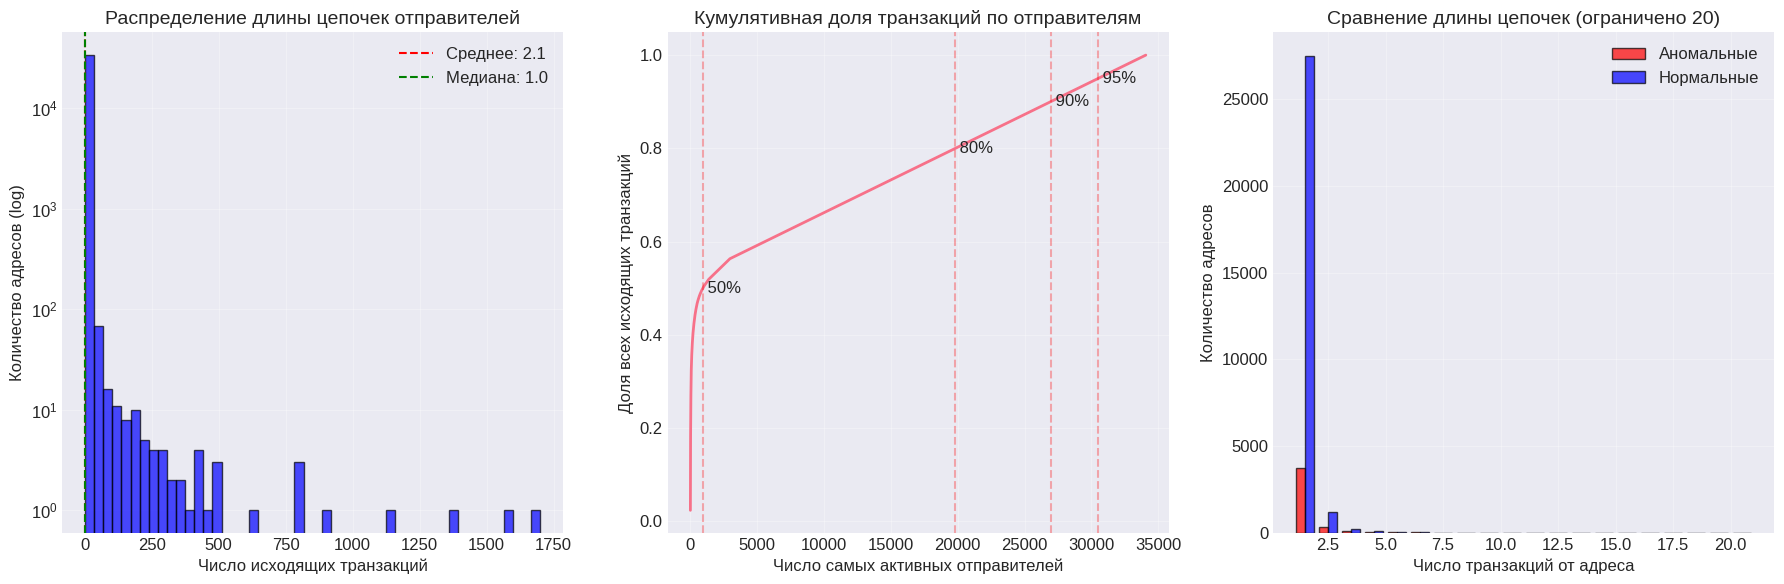

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].hist(from_counts.values, bins=50, alpha=0.7, color='blue', edgecolor='black', log=True)
axes[0].set_title('Распределение длины цепочек отправителей', fontsize=14)
axes[0].set_xlabel('Число исходящих транзакций')
axes[0].set_ylabel('Количество адресов (log)')
axes[0].axvline(from_counts.mean(), color='red', linestyle='--', 
                label=f'Среднее: {from_counts.mean():.1f}')
axes[0].axvline(from_counts.median(), color='green', linestyle='--',
                label=f'Медиана: {from_counts.median():.1f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

sorted_counts = np.sort(from_counts.values)[::-1]
cumulative = np.cumsum(sorted_counts) / np.sum(sorted_counts)

axes[1].plot(range(1, len(cumulative) + 1), cumulative, linewidth=2)
axes[1].set_title('Кумулятивная доля транзакций по отправителям', fontsize=14)
axes[1].set_xlabel('Число самых активных отправителей')
axes[1].set_ylabel('Доля всех исходящих транзакций')
axes[1].grid(True, alpha=0.3)

for perc in [0.5, 0.8, 0.9, 0.95]:
    idx = np.where(cumulative >= perc)[0][0]
    axes[1].axvline(idx+1, color='red', linestyle='--', alpha=0.3)
    axes[1].text(idx+1, perc, f' {perc*100:.0f}%', va='center')

max_display = 20
scam_sample = scam_from_counts[scam_from_counts <= max_display].values
normal_sample = normal_from_counts[normal_from_counts <= max_display].values

axes[2].hist([scam_sample, normal_sample], 
    bins=range(1, max_display+2),
    alpha=0.7,
    label=['Аномальные', 'Нормальные'],
    color=['red', 'blue'],
    edgecolor='black'
)

axes[2].set_title('Сравнение длины цепочек (ограничено 20)', fontsize=14)
axes[2].set_xlabel('Число транзакций от адреса')
axes[2].set_ylabel('Количество адресов')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 5. Анализ value

Конвертируем значения из wei в eth

In [113]:
value_series = df_transactions['value'].astype(float)

value_eth = value_series / 1e18

Статистика по суммам:

In [114]:
print(f"Средняя сумма: {value_eth.mean():.6f} ETH")
print(f"Медианная сумма: {value_eth.median():.6f} ETH")
print(f"Максимальная сумма: {value_eth.max():.6f} ETH")
print(f"Минимальная сумма: {value_eth.min():.6f} ETH")
print(f"Стандартное отклонение: {value_eth.std():.6f} ETH")

Средняя сумма: 10.023332 ETH
Медианная сумма: 0.247850 ETH
Максимальная сумма: 60000.000000 ETH
Минимальная сумма: 0.000000 ETH
Стандартное отклонение: 285.727201 ETH


Распределение сумм по процентилям:

In [115]:
value_percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
for p in value_percentiles:
    val = value_eth.quantile(p)
    print(f"{p*100:3.0f}% транзакций ≤ {val:.6f} ETH")


 10% транзакций ≤ 0.000111 ETH
 25% транзакций ≤ 0.024902 ETH
 50% транзакций ≤ 0.247850 ETH
 75% транзакций ≤ 1.499045 ETH
 90% транзакций ≤ 8.419463 ETH
 95% транзакций ≤ 27.546895 ETH
 99% транзакций ≤ 100.000000 ETH


Сравнение аномальных и нормальных транзакций

In [116]:
scam_values = value_eth[df_transactions['is_scam'] == 1]
normal_values = value_eth[df_transactions['is_scam'] == 0]

print(f"Среднее для аномальных: {scam_values.mean():.6f} ETH")
print(f"Среднее для нормальных: {normal_values.mean():.6f} ETH")

Среднее для аномальных: 1.042644 ETH
Среднее для нормальных: 12.268504 ETH


Вероятно из-за меньшего количества аномальных транзакций заметна разница и ввиду того, что крупные транзакции зачастую - нормальные, нежели чем аномальные происходит данное расхождение.

## Визуализация:

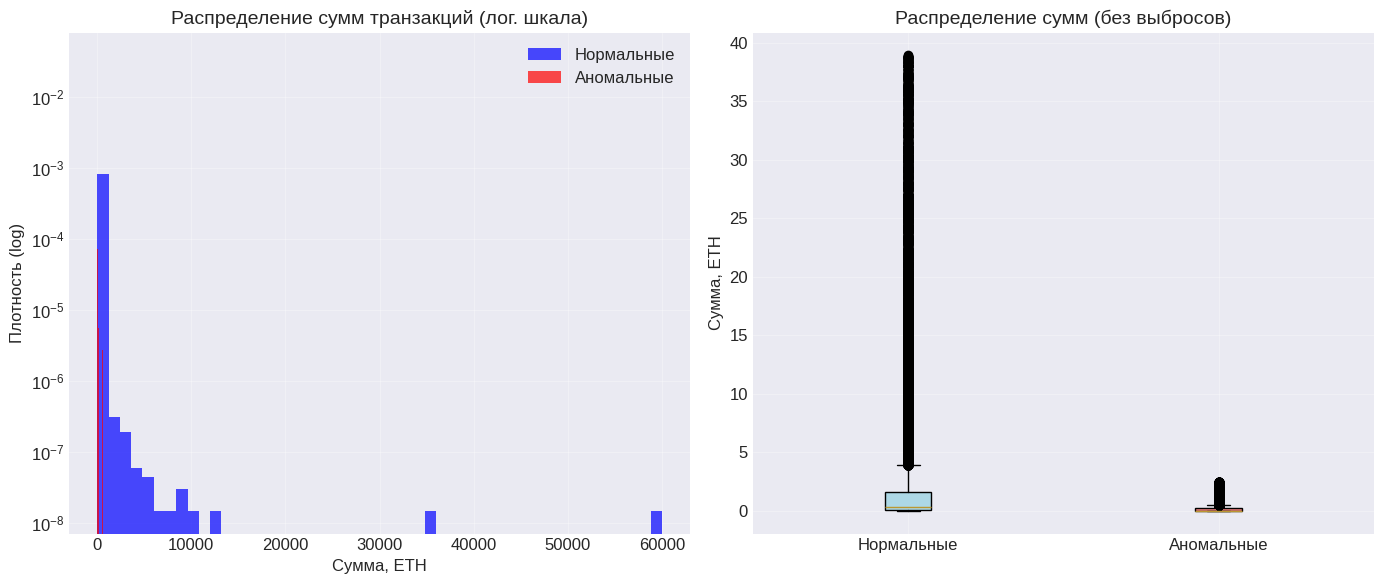

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(normal_values, bins=50, alpha=0.7, label='Нормальные', 
        color='blue', density=True, log=True)
axes[0].hist(scam_values, bins=50, alpha=0.7, label='Аномальные',
        color='red', density=True, log=True)
axes[0].set_title('Распределение сумм транзакций (лог. шкала)', fontsize=14)
axes[0].set_xlabel('Сумма, ETH')
axes[0].set_ylabel('Плотность (log)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

data_to_plot = [normal_values[normal_values <= normal_values.quantile(0.95)],
            scam_values[scam_values <= scam_values.quantile(0.95)]]

box = axes[1].boxplot(data_to_plot, labels=['Нормальные', 'Аномальные'],
                    patch_artist=True)
box['boxes'][0].set_facecolor('lightblue')
box['boxes'][1].set_facecolor('lightcoral')

axes[1].set_title('Распределение сумм (без выбросов)', fontsize=14)
axes[1].set_ylabel('Сумма, ETH')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Анализ gas (коммисии в ETH) 

In [118]:
gas_columns = ['gas', 'gas_price', 'receipt_gas_used', 'receipt_cumulative_gas_used']
available_gas_cols = [col for col in gas_columns if col in df_transactions.columns]

In [119]:
for col in gas_columns:
    print(f"\nСтатистика по колонке {col}:")
    values = df_transactions[col].astype(float)
    
    print(f"Среднее: {values.mean():.2f}")
    print(f"Медиана: {values.median():.2f}")
    print(f"Минимум: {values.min():.2f}")
    print(f"Максимум: {values.max():.2f}")
    
    Q1 = values.quantile(0.25)
    Q3 = values.quantile(0.75)
    IQR = Q3 - Q1
    outliers = values[(values < (Q1 - 1.5 * IQR)) | (values > (Q3 + 1.5 * IQR))]
    print(f"Выбросы (IQR метод): {len(outliers):,} ({len(outliers)/len(values)*100:.1f}%)")


Статистика по колонке gas:
Среднее: 68345.62
Медиана: 35000.00
Минимум: 21000.00
Максимум: 9344755.00
Выбросы (IQR метод): 3,895 (5.5%)

Статистика по колонке gas_price:
Среднее: 34492865455.16
Медиана: 20000000000.00
Минимум: 1.00
Максимум: 30000000000000.00
Выбросы (IQR метод): 3,144 (4.4%)

Статистика по колонке receipt_gas_used:
Среднее: 26270.84
Медиана: 21000.00
Минимум: 21000.00
Максимум: 6787079.00
Выбросы (IQR метод): 12,295 (17.3%)

Статистика по колонке receipt_cumulative_gas_used:
Среднее: 2946858.14
Медиана: 2338859.00
Минимум: 21000.00
Максимум: 9991824.00
Выбросы (IQR метод): 0 (0.0%)


Создадим новые признаки по gas

In [120]:
df_transactions['gas_efficiency'] = df_transactions['receipt_gas_used'] / df_transactions['gas']
df_transactions['gas_efficiency'] = df_transactions['gas_efficiency'].replace([np.inf, -np.inf], np.nan)

efficiency = df_transactions['gas_efficiency'].dropna()

Статистика по колонке gas_efficiency:

In [121]:
print(f"Средняя: {efficiency.mean():.3f}")
print(f"Медиана: {efficiency.median():.3f}")
print(f"< 0.5: {(efficiency < 0.5).sum():,} транзакций")
print(f"> 0.9: {(efficiency > 0.9).sum():,} транзакций")

Средняя: 0.670
Медиана: 0.833
< 0.5: 25,109 транзакций
> 0.9: 28,433 транзакций


Анализ для аномальных транзакций

In [122]:
scam_efficiency = df_transactions.loc[df_transactions['is_scam'] == 1, 'gas_efficiency'].dropna()
normal_efficiency = df_transactions.loc[df_transactions['is_scam'] == 0, 'gas_efficiency'].dropna()

print(f"Среднее для аномальных: {scam_efficiency.mean():.3f}")
print(f"Среднее для нормальных: {normal_efficiency.mean():.3f}")

Среднее для аномальных: 0.714
Среднее для нормальных: 0.660


Подводя итог, проанализировав данные - можно сказать, что:
 - 1. В данной работе с целью обнаружения аномальных транзакций мы не сможем использовать совмещенно датасет транзакций с датасетом с аккаунтами (добавлять к транзакциям признаки с адресов), т.к. иначе получится, что мы будем добавлять информацию из будущего по аккаунтам в транзакции, т.е. добавлять статистику на следующие транзакции к аккаунтам, что приведёт к временное утечке, а также сместит нашу цель с обнаружения в реальном времени на обнаружение по истории транзакций.

 - 2. Датасет транзакций достаточно хорошо обработан и в него можно внести разве что несколько новых синтетических переменных, он содержит достаточное количество аномальных транзакций, но есть ограничения, такие как:
    - Смещенность аномальных транзакций к самым поздним транзакциям (нельзя разделять данные на train/test/val хронологически т.к. рапсределения будут крайне разнится)
    - Количество транзакций на каждый адрес мала для решений с помощью transformer/lstm/rnn архитектур (Средняя длинна - 2.1)